In [3]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%run functions/preprocess.py
%run functions/linear_regression.py

np.set_printoptions(formatter={'float_kind': '{:f}'.format})
pd.set_option('display.float_format', lambda x: '%.3f' % x)
plt.style.use('seaborn')

## Loading the data

In [4]:
df_data = pd.read_pickle('processed2017.pkl')
df_data = df_data.drop(['time of day', 'weekday', 'Unix', 'next_event', 'prev_event',
                        'nextUnix', 'prevUnix', 'prevTime', 'event org:resource'], axis=1)


# should actually be done after splitting
df_data = encode(df_data)
df_data = time_diff(df_data, outlier='keep')


df_data.drop(['loangoal_Debt restructuring',
 'eventname_W_Personal Loan collection',
 'action_Deleted',
 'action_Obtained',
 'action_Released',
 'eventname_O_Accepted',
 'eventname_W_Assess potential fraud',
 'origin_Workflow',
 'hour',
 'action_statechange',
 'loangoal_Car',
 'origin_Offer',
 'lifecycle_complete',
 'appl_type_New credit', 
 'day_of_week'], axis=1, inplace = True)


In [5]:
def sliding_window(window_size, df):
    """transforms df_data into supervised form 
    with rolling window implementations

    Args:
        window_size (int): size of rolling window

    Returns:
        (X, Y): tuple of input and output arrays
    """

    windows = list(df.rolling(window=window_size))
    for i in windows[window_size-1:]:
        # split into X and Y
        i = i.drop('case concept:name', axis=1)
        temp = i.to_numpy()
        temp = [item for sublist in temp for item in sublist]
        Y.append(temp.pop(-1))
        X.append(temp)
    return None


In [6]:
from sklearn.model_selection import train_test_split
np.random.seed(1587)
df_train, df_test = train_test_split(df_data, test_size=0.3, shuffle=False)


# randomly sample traces from log
# df_train = df_train[df_train['case concept:name'].isin(np.random.choice(
#     df_train['case concept:name'].unique(), size=2000, replace=True))]
df_train.shape

(819529, 48)

In [7]:
df_train['case concept:name'].nunique()
cases = df_train['case concept:name'].unique()[15000:]
df_train = df_train[df_train['case concept:name'].isin(cases)]
df_train, df_test = del_intersection(df_train, df_test)


---

## Training

In [8]:
# X_train = pd.DataFrame(X)

In [9]:
# Y_train = pd.DataFrame(Y).rename(columns={0:'y'})

In [10]:
# df_train = pd.concat([X_train, Y_train], axis=1)

In [11]:
# df_train

In [12]:
from statsmodels.formula.api import ols

X = []
Y = []

# transform into windows
df_train.groupby('case concept:name').apply(lambda x: sliding_window(3, x))

# cross validation and training
cv = cross_validate(np.array(X), np.array(Y))
model = cv[1]


# model = sm.OLS(Y, X)
# model = model.fit()
        
# model = ols("y ~ x + y", df_train).fit()

# y_pred = model.predict(X_test)

In [13]:
df_data

,case concept:name,case RequestedAmount,day,month,hour_cos,hour_sin,day_of_week_cos,day_of_week_sin,loangoal_Business goal,loangoal_Caravan / Camper,...,eventname_W_Handle leads,eventname_W_Shortened completion,eventname_W_Validate application,lifecycle_resume,lifecycle_schedule,lifecycle_start,lifecycle_suspend,lifecycle_withdraw,next_time,time_diff
0,Application_652823628,0.044,1,1,-0.917,0.398,-0.500,-0.866,0,0,...,0,0,0,0,0,0,0,0,0.000,0.000
1,Application_652823628,0.044,1,1,-0.917,0.398,-0.500,-0.866,0,0,...,1,0,0,0,1,0,0,0,0.000,4.394
2,Application_652823628,0.044,1,1,-0.917,0.398,-0.500,-0.866,0,0,...,1,0,0,0,0,0,0,1,81.000,0.000
3,Application_652823628,0.044,1,1,-0.917,0.398,-0.500,-0.866,0,0,...,0,0,0,0,1,0,0,0,0.000,0.000
4,Application_652823628,0.044,1,1,-0.917,0.398,-0.500,-0.866,0,0,...,0,0,0,0,0,0,0,0,0.000,11.403
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1170752,Application_637536789,0.038,1,2,-0.577,-0.817,-0.500,0.866,0,0,...,0,0,0,0,0,0,0,0,387.000,0.000
1170753,Application_637536789,0.038,1,2,-0.577,-0.817,-0.500,0.866,0,0,...,0,0,1,0,1,0,0,0,0.000,0.000
1170754,Application_637536789,0.038,1,2,-0.577,-0.817,-0.500,0.866,0,0,...,0,0,1,0,0,1,0,0,0.000,0.000
1170755,Application_637536789,0.038,1,2,-0.577,-0.817,-0.500,0.866,0,0,...,0,0,0,0,0,0,0,0,0.000,3.989


In [14]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

error = cv[0]

mse = np.mean([mean_squared_error(i[0], i[1]) for i in error])
r2 = np.mean([r2_score(i[0], i[1]) for i in error])
mae = np.mean([mean_absolute_error(i[0], i[1]) for i in error])
rmse = np.mean([mean_squared_error(i[0], i[1], squared=False) for i in error])
print(f'mse: {np.exp(mse)}\nr^2: {r2}\nrmse: {np.exp(rmse)}\nmae:{np.exp(mae)}')


mse: 65.15184827881895
r^2: 0.7769640545033771
rmse: 7.718781459430972
mae:4.17865649513634


---

## Results

In [7]:
# df_test = encode(df_test)
# df_test = time_diff(df_test)


In [15]:
X = []
Y = []
# transform into windows
df_test.groupby('case concept:name').apply(lambda x: sliding_window(3, x))


""


In [16]:
y_pred = model.predict(X)
mse = mean_squared_error(Y, y_pred)
r2 = r2_score(Y, y_pred)
mae = mean_absolute_error(Y, y_pred)
rmse = mean_squared_error(Y, y_pred, squared=False)
print(f'mse: {np.exp(mse)}\nr^2: {r2}\nrmse: {np.exp(rmse)}\nmae:{np.exp(mae)}')


mse: 20504.035448804345
r^2: 0.4614873289121133
rmse: 23.357840715504132
mae:6.299143281261598


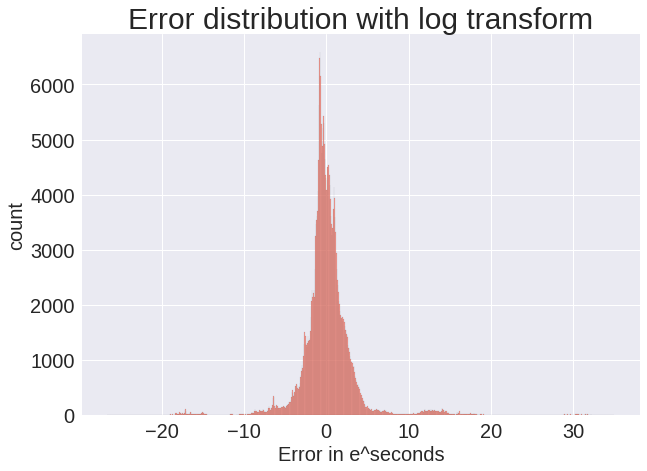

In [17]:
y_true = pd.DataFrame(Y)
y_pred = pd.DataFrame(y_pred)
df_error = pd.concat([y_true, y_pred], axis=1)
df_error.columns = ['y_true', 'y_pred']
df_error.reset_index(inplace=True)
df_error['error'] = df_error['y_true'] - df_error['y_pred']

fig, ax = plt.subplots(figsize=(10, 7))
# df_error.plot.hist(x='index', y='error', figsize=(10,5), ax=ax, bins=10)
sns.histplot(data=df_error, x='error', ax=ax, color='salmon')
ax.set_title('Error distribution with log transform', size=30)
ax.set_ylabel('count', fontsize=20)
ax.set_xlabel('Error in e^seconds', fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20);


In [12]:
# cols = df_data.columns.tolist()
# cols.remove('time_diff')
# cols = cols + ['time_diff']
# df_data = df_data[cols]

# categorial = ['case LoanGoal']
# numerical = ['case RequestedAmount']
# df_data.drop(categorial, axis=1).drop(numerical, axis=1)


In [13]:
# from statsmodels.stats.outliers_influence import variance_inflation_factor
  

# # the independent variables set
# X = df_train.drop(['time_diff','case concept:name'], axis=1)
  
# # VIF dataframe
# vif_data = pd.DataFrame()
# vif_data["feature"] = X.columns
  
# # calculating VIF for each feature
# vif_data["VIF"] = [variance_inflation_factor(X.values, i)
#                           for i in range(len(X.columns))]
  
# print(vif_data)

In [ ]:
# import numpy as np
# import statsmodels.api as sm
# import pylab as py
  
# # np.random generates different random numbers
# # whenever the code is executed
# # Note: When you execute the same code 
# # the graph look different than shown below.
  
# # Random data points generated
# data_points = np.random.normal(0, 1, 100)    
  
# sm.qqplot(df_error['error'], line ='45')
# py.show()